In [9]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [10]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

In [11]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-2,-2))
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(0,2*math.sqrt(3)-2))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,-5.0),np.random.uniform(-5.0,-5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-2.0,2.0),np.random.uniform(-2.0,2*math.sqrt(3)-2),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    world.ani.save('C:\\Users\\tauyu\\Videos\\Captures\\センサリセット(正三角形)3.gif',writer='imagemagick',fps=1)
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


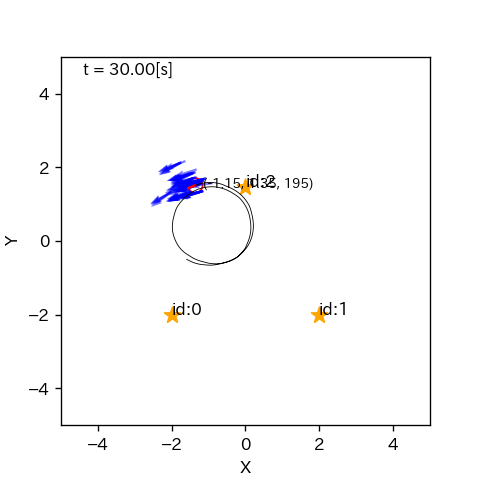

MovieWriter imagemagick unavailable; using Pillow instead.


[3.639567826828724]
[3.9487697721745123, 2.1405135450527033]


(array([-1.97822358,  0.45444579,  4.63612589]),
 array([-2.08351319,  0.85446357,  4.57950987]))

In [14]:
trial_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[4.503799461583418, 1.1094377540978715]
0 真値: [-2.43852654  1.95488266  4.80079508] 推定値: [-2.75980674  1.57076901  4.85291896] 誤差: 0.5007636839003533
1
[2.551281260987891]
[2.657979454055647]
1 真値: [2.81844552 2.97166686 2.81288783] 推定値: [-1.92697124  3.05574129 -1.42762857] 誤差: 4.7461614726888754
[1.4062748889334524]
[5.074991746034026, 0.6692972488674503]
2 真値: [-0.77147771  0.14455499  5.35713467] 推定値: [-0.73296767  0.16362822 -0.88783792] 誤差: 0.04297454428499784
2
[2.9284820897825785, 3.6875406267832944]
3 真値: [-0.65742729  2.42061149  3.72261902] 推定値: [-0.76555422  1.98494427  3.6820089 ] 誤差: 0.4488845758244638
3
[3.210780558525781]
4 真値: [ 2.81772101 -1.12085048  1.99147216] 推定値: [ 2.60938677 -0.97813194  1.99475166] 誤差: 0.2525306718771881
4
[4.733740615959926]
[3.553209253198402, 1.973884936513697]
5 真値: [ 3.51786325 -0.87801734  1.87160604] 推定値: [ 3.28162518 -0.64559359  1.81115499] 誤差: 0.33140492956343826
5
[2.1146749522942576]
6 真値: [-0.53652057 -0.53678592  3.32598157] 推定値: 

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[3.5076322880976036]
20 真値: [2.56351678 0.48015493 2.74501508] 推定値: [2.64209099 0.16746174 2.6753528 ] 誤差: 0.3224142295778883
19
[2.4381259232416626]
[2.640639114865047]
[1.413189641548056, 5.221957310829152]
21 真値: [-1.18350243 -0.73869546  7.58361276] 推定値: [-1.34015642 -0.75010214  1.11874672] 誤差: 0.15706872637024616
20
[1.7697534245975488]
22 真値: [-0.78931085 -1.31588572  6.17708708] 推定値: [-0.65656807 -1.28299104  6.13430106] 誤差: 0.13675783729451507
21
[2.182196551629145]
23 真値: [1.27675784 0.12358075 6.13740025] 推定値: [ 1.18737417  0.24204732 -0.1508853 ] 誤差: 0.14840407626096175
22
[4.26563437776054]
24 真値: [ 1.73370074 -2.06141147  7.61806102] 推定値: [ 1.51159347 -2.10752164  7.46985364] 誤差: 0.22684308928096994
23
[2.516157048809254]
25 真値: [ 1.71070423 -2.27966194  7.97769432] 推定値: [ 1.67638059 -2.39168414  1.69666086] 誤差: 0.11716263962329189
24
[3.209909283315886]
26 真値: [ 1.18194335 -1.98130017  8.1624265 ] 推定値: [ 1.09142573 -2.26407943  8.0482672 ] 誤差: 0.2969133647185636
25
[1.23